### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator.
Installer ensuite deeplib avec la commande suivante:

In [1]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

  Cloning https://github.com/ulaval-damas/glo4030-labs.git to /tmp/pip-req-build-cv_xvnkp
  Running command git clone --filter=blob:none --quiet https://github.com/ulaval-damas/glo4030-labs.git /tmp/pip-req-build-cv_xvnkp
  Resolved https://github.com/ulaval-damas/glo4030-labs.git to commit c18815c2c3080b82b6db4c66f66a57367149a723
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 77.2 MB/s eta 0:00:00
  Created wheel for deeplib: filename=deeplib-0.1-py3-none-any.whl size=10542 sha256=c8b51a3c86b0c8af2ddc146d3182d6b2c92dab799f6ed4670b47e6e107817d94
  Stored in directory: /tmp/pip-ephem-wheel-cache-jmb0tzi2/wheels/9f/29/ed/25822e0088ad9c46b352ed51c58696b9d13fbc94e1db2ac759
Successfully built deeplib


# Laboratoire 3: Optimisation

## Partie 1: Fonctions d'optimisation

Dans cette section, vous testerez différentes fonctions d'optimisation et observerez leurs effets sur l'entraînement.

In [2]:
%matplotlib inline

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import poutyne as pt

from deeplib.history import History
from deeplib.datasets import train_valid_loaders, load_cifar10

from torchvision.transforms import ToTensor

from deeplib.net import CifarNet

from deeplib.datasets import train_valid_loaders, load_mnist, load_cifar10
from deeplib.training import train, validate_ranking, test
from deeplib.visualization import show_2d_function, show_optimization, show_worst, show_random, show_best

plt.rcParams['figure.dpi'] = 150

### 1.1 Un exemple jouet

On va commencer par explorer les effets des variantes de SGD avec un exemple jouet. L'exemple jouet va consister en une régression linéaire simple en 2 dimensions avec laquelle on sera en mesure de visualiser l'impact des différentes variantes de SGD. En effet, dans cette section, on va jouer avec trois paramètres de SGD: le taux d'apprentissage, le momentum et l'accélération de Nesterov.

Initialisations notre jeu de données jouet qui va contenir seulement 3 points en 2 dimensions ainsi que 3 valeurs à régresser.

In [3]:
x = torch.tensor([[1,1],[0,-1],[2,.5]], dtype=torch.float32)
y = torch.tensor([[-1.], [3], [2]], dtype=torch.float32)

Lors d'une régression linéaire, on souhaite trouver des poids $w^*$ qui minimise pour chaque exemple $(x_i, y_i)$ la perte quadratique entre $x_i \cdot w$ et $y_i$. Mathématiquement, voici la fonction que l'on souhaite optimiser:
$$F(w) = \frac{1}{n} \sum_{i=1}^{n} (x_i \cdot w - y_i)^2$$
On souhaite donc trouver les poids optimaux $w^*$ qui minimise $F(w)$.
$$w^* = \text{argmin}_w F(w)$$
La cellule ci-dessous est cette fonction objectif en fonction des paramètres $w$ que l'on souhaite trouver.

In [4]:
def objective_function(w):
    return torch.mean((x @ w - y) ** 2, dim=0)

Comme vous vous en rappelez peut-être, la solution d'une régression linéaire a une forme analytique qui est la suivante.
$$w^* = (X^TX)^{-1}X^TY$$
La cellule ci-dessous trouve la solution pour notre problème jouet en utilisant cette formule.

In [5]:
w_opt = torch.inverse(x.T @ x) @ x.T @ y

Nous allons utiliser la fonction `show_2d_function` de la librairie `deeplib`. La librairie `deeplib` est une libraire écrite spécialement pour les notebook de ce cours. La fonction `show_2d_function` permet de visualiser notre fonction objectif avec des courbes de niveau. Les deux axes correspondent à différentes valeurs pour les 2 poids respectifs de $w$ pour notre régression linéaire en 2 dimensions. La couleur des courbes de niveau donne la valeur de la fonction objectif. L'étoile rouge correspond à $w^*$, notre valeur optimale des poids.

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


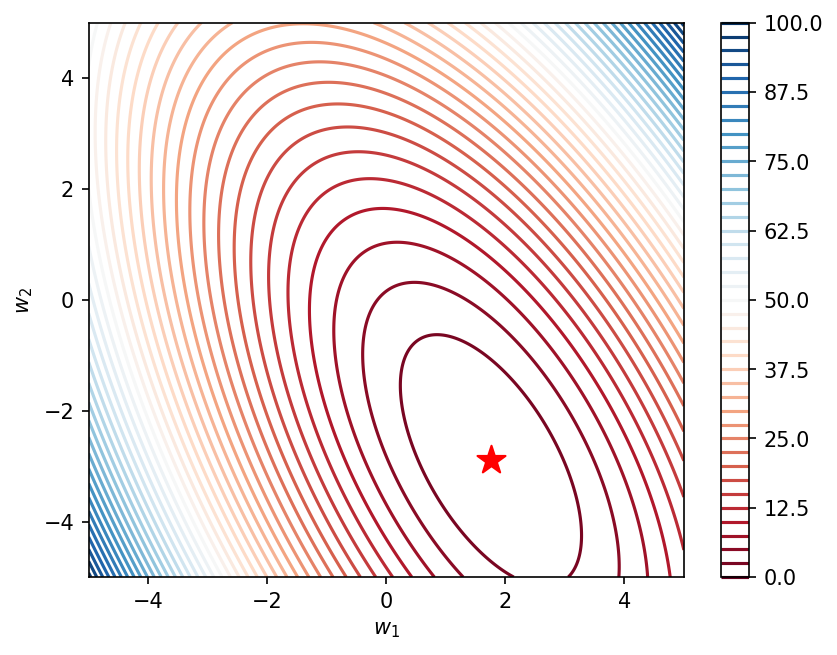

In [6]:
show_2d_function(objective_function, optimal=w_opt)

Les prochaines cellules définissent deux fonctions.

La première fonction se charge d'optimiser notre fonction objectif à la manière des réseaux de neurones en utilisant l'optimiseur SGD de PyTorch. La fonction retourne l'historique des poids $w$ de chaque itération ainsi que l'historique des valeurs de perte. Des commentaires dans cette fonction ont été laissés afin que vous puissiez comprendre le déroulement de l'optimisation.

In [7]:
def optimize(learning_rate, momentum, nesterov, nb_iter=20):
    """
    Optimise la fonction objectif à la manière de PyTorch avec l'optimiseur SGD.

    Args:
        learning_rate: Le taux d'apprentissage.
        momentum: La valeur du momentum.
        nesterov: Si l'accélération de Nesterov est désirée.
        nb_iter: Le nombre d'itérations effectué.

    Returns:
        Tuple `(w_history, loss_history)` où `w_history` correspond à
        l'historique des poids lors de l'optimisation et `loss_history`
        correspond à l'historique de la valeur de la fonction objectif
        ou fonction de perte dans le cadre des réseaux de neurones.
    """
    torch.manual_seed(42)

    # Notre réseau: une couche linéaire sans biais. Essentiellement, 2 poids.
    neuron = nn.Linear(2, 1, bias=False)

    # La fonction de perte quadratique.
    loss_function = nn.MSELoss()

    # Initialise l'optimiseur SGD
    optimizer = optim.SGD(neuron.parameters(), lr=learning_rate, momentum=momentum, nesterov=nesterov)

    # À la différence des réseaux de neurones, on ne divise pas en epochs
    # et en batchs étant donné que notre jeu de données contient seulement
    # 3 points et que notre problème est convexe et donc résoluble avec une
    # simple descente de gradient. On fera donc un certain nombre d'itérations
    # pour trouver la solution du problème. On pourrait voir une itération comme
    # un epoch avec une seule batch contenant le jeu de données entier.
    # Pour chaque itération, on y va à
    # la manière des réseaux de neurones:
    # - On effectue une prédiction;
    # - On calcule notre perte;
    # - On fait la rétropropagation (backpropagation) via la méthode backward();
    # - On met à jour les poids avec l'optimiseur.
    w_history = []
    loss_history = []
    for t in range(nb_iter):
        y_pred = neuron(x)
        loss = loss_function(y_pred, y)
        w_history.append(neuron.weight.squeeze(0).detach().clone().numpy())
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return w_history, loss_history

La deuxième fonction trace des graphiques permettant de visualiser l'optimisation effectuée par la première fonction. La fonction ne fait qu'appeler la fonction `show_optimization` définie dans `deeplib` en lui passant en paramètre les historiques retournées par la fonction d'optimisation, la fonction objectif ainsi que les paramètres optimaux que nous avons calculés.

In [8]:
def show_objective_optimization(w_history, loss_history, **kwargs):
    return show_optimization(w_history, loss_history, objective_function, optimal=w_opt, **kwargs)

On va utiliser ces deux fonctions pour pouvoir visualiser l'impact de trois paramètres de SGD: le taux d'apprentissage, le momentum et l'accélération de Nesterov.

In [9]:
learning_rate = 0.3
momentum = 0
nesterov = False

Optimisons maintenant notre fonction avec les valeurs ci-dessus.

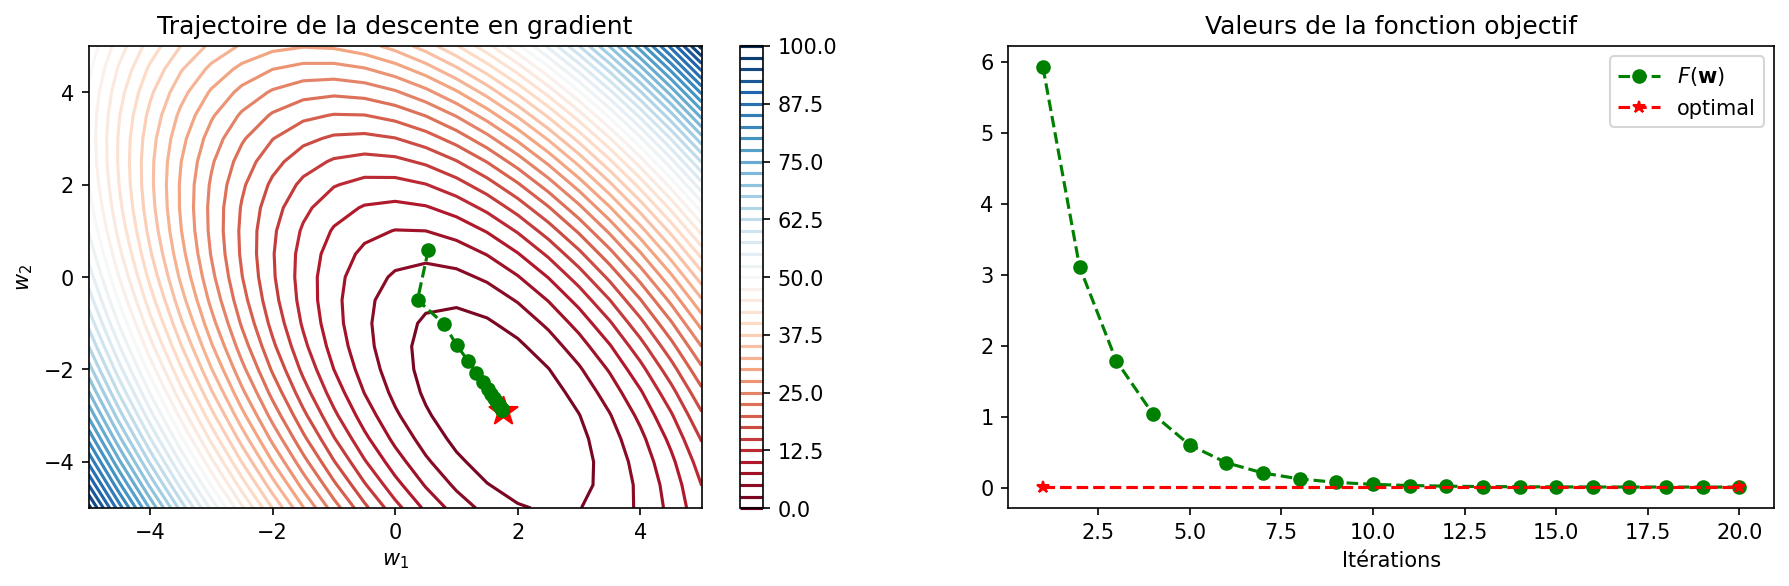

In [10]:
w_history, loss_history = optimize(learning_rate, momentum, nesterov)
show_objective_optimization(w_history, loss_history)

On voit qu'après 10 itérations, l'optimisation a relativement convergé.

#### Exercices

Pour les exercices ci-dessous, vous pouvez utiliser des fonctions comme [`numpy.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html), [`numpy.logspace`](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) ou [`numpy.geomspace`](https://numpy.org/doc/stable/reference/generated/numpy.geomspace.html) permettant d'obtenir une liste de valeurs à tester.

- Testez différentes valeurs entre 0 et 1 du taux d'apprentissage en complétant la cellule ci-dessous.

In [ ]:
momentum = 0.
nesterov = False
for learning_rate in [0.0001, 0.001, 0.01, 0.1]: # TODO à compléter avec différentes valeurs
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_objective_optimization(w_history, loss_history, title=f"Learning rate: {learning_rate:.2g}")

- Testez différentes valeurs entre 0 et 1 pour le momentum en complétant la cellule ci-dessous.

In [ ]:
learning_rate = 0.3
nesterov = False
for momentum in [...]: # TODO à compléter avec différentes valeurs
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_objective_optimization(w_history, loss_history, title=f"Momentum: {momentum:.2g}")

- Testez différentes valeurs entre 0 et 1 pour le momentum avec l'accélération de Nesterov en complétant la cellule ci-dessous.

In [ ]:
learning_rate = 0.3
nesterov = True
for momentum in [...]: # TODO à compléter avec différentes valeurs
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_objective_optimization(w_history, loss_history, title=f"Momentum: {momentum:.2g} avec Nesterov")

#### Questions
- Que pouvons-nous remarquer sur l'impact du taux d'apprentissage sur l'optimisation?
- Que pouvons-nous remarquer sur l'impact du momentum sur l'optimisation?
- Que pouvons-nous remarquer sur l'impact de l'accélération de Nesterov sur l'optimisation?

### 1.2 Un exemple plus près de la réalité

Testons maintenant différents optimiseurs sur un vrai réseau de neurones avec un vrai jeu de données. Comme dans les labos précédents, on utilise le jeu de données CIFAR10 avec un simple réseau à convolution.

Initialisons le jeu de données et quelques hyperparamètres qui vont rester constants.

In [ ]:
cifar_train, cifar_test = load_cifar10()

In [ ]:
batch_size = 128
lr = 0.01
n_epoch = 10

Pour le reste de ce notebook et dans les prochains laboratoires, nous allons utiliser la fonction `train` qui est définie dans la librairie `deeplib`. La fonction utilise la librairie [Poutyne](https://poutyne.org). Comme vu dans le laboratoire 1, Poutyne nous donne un meilleur affichage de l'évolution de l'entraînement comparativement à notre boucle d'entraînement personnalisée que nous avions fait à la main. Comme on va le voir plus loin, l'utilisation de Poutyne implique nous allons devoir utiliser des callbacks de Poutyne pour les horaires d'entraînement.

#### Exercice

 - Comparez trois différentes stratégies d'optimisation:
1. [SGD](http://pytorch.org/docs/master/optim.html#torch.optim.SGD)
2. SGD + Momentum accéléré de Nesterov
3. [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam)

Commençons par l'entraîner avec SGD (sans momentum ni accélération de Nesterov).

In [ ]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)
history_sgd = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_sgd.display()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

 - Complétez cette cellule pour entraîner avec SGD + Momentum accéléré de Nesterov. Utilisez un momentum de 0.9.

In [ ]:
model = CifarNet()
model.cuda()
#optimizer =
history_SGDMN = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_SGDMN.display()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

 - Complétez cette cellule pour entraîner avec Adam

In [ ]:
model = CifarNet()
model.cuda()
#optimizer =
history_adam = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_adam.display()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Questions
- Quelle méthode semble être la meilleure dans ce cas-ci?
- Remarquez-vous une différence d'overfitting?
- Dans une nouvelle cellule, changez le taux d'apprentissage de Adam pour 0.001. Que remarquez-vous maintenant?

Pour la réponse à la question 3:

In [ ]:
model = CifarNet()
model.cuda()
#optimizer =
history_adam = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_adam.display()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Partie 2: Horaire d'entraînement

Une pratique courante utilisée en apprentissage profond est de faire diminuer le taux d'apprentissage pendant l'entraînement.

Pour ce faire, PyTorch fournit plusieurs fonctions (ExponentialLR, LambdaLR, MultiStepLR, etc.).  Dans ce notebook, on utilisera les [callbacks correspondant de Poutyne](https://poutyne.org/callbacks.html#lr-schedulers) qui cachent sous le capot les fonctions de PyTorch.

Voici un exemple avec ExponentialLR.

In [ ]:
model = CifarNet()
model.cuda()

batch_size = 128
lr = 0.01
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

gamma = 0.8
scheduler = pt.ExponentialLR(gamma)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Affichons la valeur du taux d'apprentissage.

In [ ]:
history.display(display_lr=True)

#### Exercice

- Utilisez [MultiStepLR](http://pytorch.org/docs/master/optim.html#torch.optim.lr_scheduler.MultiStepLR) pour modifier le taux d'apprentissage pour un epoch précis.

1. Commencez avec un taux d'apprentissage trop élevé pour que le réseau puisse apprendre quelque chose.
2. Diminuez-le progressivement jusqu'à ce que le réseau apprenne.
3. Trouvez le moment où la validation semble avoir atteint un plateau.
4. Diminuez le taux par 2 à ce moment et réentraîner le réseau.

In [ ]:
torch.manual_seed(42)
model = CifarNet()
model.cuda()

epoch_list = [] # TODO liste à remplir au fur et à mesure que les points 3 et 4 sont itérés.

batch_size = 128
lr = 10
n_epoch = 20

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = pt.MultiStepLR(milestones=epoch_list, gamma=0.5)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

In [ ]:
history.display(display_lr=True)

#### Questions
- Voyez-vous une différence en diminuant le taux d'apprentissage par 2 après x epochs?
- Pourquoi?

### Pour aller plus loin sur les horaires d'entraînement

On vient de faire "à la main" ce que la classe [ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau) de PyTorch nous permet de faire automatiquement. Essentiellement, cette classe nous permet de monitorer une métrique et de réduire le taux d'apprentissage lorsque cette métrique stagne pour un certain nombre d'epochs. Ce nombre d'epoch est appelé la "patience". Nous allons utiliser le callback [poutyne.ReduceLROnPlateau](https://poutyne.org/callbacks.html#poutyne.ReduceLROnPlateau) de Poutyne qui prend en paramètre le nom de la métrique à monitorer en plus des autres arguments de la classe de PyTorch.

Notez bien la description du paramètre `patience` dans la documentation de PyTorch:
> **patience** - Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then.

Dans la cellule ci-dessous, on monitore l'exactitude en validation avec une patience de 1 epoch.

In [ ]:
torch.manual_seed(42)
model = CifarNet()
model.cuda()

batch_size = 128
lr = 0.5
n_epoch = 20

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=1, factor=0.5)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

In [ ]:
history.display(display_lr=True)

## Partie 3: Batch Normalization

Voici l'architecture du réseau de neurones convolutionnels que vous avez utilisé jusqu'à présent pour faire de la classification sur Cifar10.

In [ ]:
import torch.nn.functional as F

class CifarNetBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 50, 3, padding=1)
        self.conv3 = nn.Conv2d(50, 150, 3, padding=1)
        self.fc1 = nn.Linear(150 * 8 * 8, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = x.flatten(1)
        x = self.fc1(x)
        return x

#### Exercice

- Modifier l'architecture du réseau en ajoutant de la batch normalization entre les couches de convolutions et les ReLUs (essentiellement, on devait avoir `Conv2d -> BatchNorm2d -> ReLU`) et entraîner le nouveau réseau.

In [ ]:
model = CifarNetBatchNorm()
model.cuda()

lr = 0.01
batch_size = 128
n_epoch = 5

optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history.display()

#### Questions

- Comparer l'entraînement du réseau avec et sans la batch normalization (Section 1.2 avec SGD, où on a entraîné le réseau sans batch normalization avec le même taux d'apprentissage). Que remarquez-vous?

### Effet de la batch normalization sur le taux d'apprentissage

Commençons par entraîner un réseau avec un taux d'apprentissage élevé. Vous pouvez augmenter le nombre d'epochs si vous voulez voir une plus grande différence.

In [ ]:
lr = 0.5
batch_size = 1024
n_epoch = 5

In [ ]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Essayons maintenant d'entraîner le réseau utilisant la batch normalization avec les mêmes hyperparamètres.

In [ ]:
model = CifarNetBatchNorm()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

#### Questions
- Que pouvez-vous conclure sur l'effet de la batch normalization sur le taux d'apprentissage?

### Analyse

Après l'entraînement, il est important d'analyser les résultats obtenus.
Commençons par tester le réseau en utilisant la fonction `validate_ranking`.
Cette fonction sépare les résultats bien classés des erreurs et retourne pour chaque image, un score (qu'on peut voir comme une probabilité), la vraie classe et la classe prédite.

In [ ]:
good, errors = validate_ranking(model, cifar_test, batch_size, use_gpu=True)

Maintenant, regardons quelques exemples d'images bien classés.

In [ ]:
show_random(good)

Et quelques exemples mal classés.

In [ ]:
show_random(errors)

Il est aussi possible de regarder les exemples où le réseau est le plus confiant.

In [ ]:
show_best(good)

Ou l'inverse, ceux qui ont obtenus les moins bons scores.

In [ ]:
show_worst(errors)

Finalement, il peut être intéressant de regarder les exemples les plus difficiles.
Soit ceux qui ont été bien classés, mais qui ont eu un mauvais score.

In [ ]:
show_worst(good)

Ou ceux qui ont été mal classés, mais qui ont quand même réussi à obtenir un bon score.

In [ ]:
show_best(errors)

#### Questions
- En observant les résultats obtenus, que pouvez-vous dire sur les performances du réseau?
- Quelle classe semble être facile? Pourquoi?
- Quelle classe semble être difficile? Pourquoi?

## Partie 4: Initialisation des poids

Dans cette section, vous testerez différentes techniques d'initialisations et observerez leurs effets sur le gradient et l'entraînement.

In [ ]:
cifar_train, cifar_test = load_cifar10()
cifar_train.transform = ToTensor()
cifar_test.transform = ToTensor()

train_loader, valid_loader = train_valid_loaders(cifar_train, 10)

On crée ici un réseau de neurones assez simple composé de 5 couches cachées (6 couches au total) et avec un choix pour la fonction d'activation.

In [ ]:
activations = dict(
    tanh=nn.Tanh,
    relu=nn.ReLU
)

def create_fully_connected_network(activation):
    assert activation in activations
    activation = activations[activation]
    num_neurons = 1000
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(32*32*3, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, num_neurons),
        activation(),
        nn.Linear(num_neurons, 10)
    )

On va jouer avec différentes fonctions d'initialisation. Créons donc une fonction nous permettant d'initialiser tous les poids de notre réseau de neurones.

In [ ]:
def initialize_network(network, initialization_function):
    for module in network.modules():
        if isinstance(module, nn.Linear):
            initialization_function(module.weight)
            init.zeros_(module.bias)

On s'intéresse aux gradients qui circulent dans le réseau de neurones lors de la rétropropagation de manière générale.
Ceci est à distinguer du gradient calculé pour chacun des poids individuels du réseau de neurones.
Le gradient circulant pendant la rétropropagation nous donne une idée de la possibilité de changements des poids de la couche en question.
Étant donné que le gradient est le même lors de l'addition, on peut se servir du biais pour mesurer le gradient circulant dans le réseau.
Les fonctions suivantes procèdent donc de la façon suivante:
- On parcourt le jeu de données d'entraînement en batch;
- Pour chacune des batchs, on garde pour chacune des couches le gradient des biais de la couche;
- Une fois que toutes les batchs ont été traitées, on calcule un histogramme des gradients pour chaque couche.

In [ ]:
def save_gradient(sequential_network, output_dictionary):
    layer_number = 1
    for layer in sequential_network:
        if isinstance(layer, nn.Linear):
            # On ignore la dernière couche qui est la couche de
            # classification.
            if layer_number == 6:
                continue

            with torch.no_grad():
                grad = layer.bias.grad.flatten().cpu().numpy()
            grad = grad[grad != 0]
            output_dictionary[layer_number].append(grad)
            layer_number += 1

def plot_gradients_per_layer(gradients_per_layer):
    for layer_number, grads in gradients_per_layer.items():
        grad = np.concatenate(grads)
        hist, bin_edges = np.histogram(grad, bins=100)
        hist = hist / hist.sum() * 100

        plt.plot(bin_edges[:-1], hist, label=f'Layer {layer_number}')

def plot_gradient(network):
    gradients_per_layer = defaultdict(list)
    network.cuda()
    for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()

        output = network(x)
        loss = F.cross_entropy(output, y)
        loss.backward()

        save_gradient(network, gradients_per_layer)

        network.zero_grad(True)

    plot_gradients_per_layer(gradients_per_layer)
    plt.title('Gradient histogram')
    plt.xlabel('Gradient value')
    plt.ylabel('Count')
    plt.legend()

La fonction ci-dessous est la fonction qui est utilisée comme référence dans [l'article introduisant l'initialisation Glorot/Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) et est d'ailleurs celle utilisé par PyTorch par défaut dans les couches linéaires. Nous allons l'utiliser pour la comparer avec l'initialisation de Glorot/Xavier et celle de Kaiming He.

In [ ]:
def standard_uniform(weight):
    bound = 1. / np.sqrt(weight.shape[1])
    init.uniform_(weight, -bound, bound)

### 4.1 Réseau avec activation tanh

La fonction tanh était la fonction d'activation la plus utilisée avant l'arrivée de la fonction ReLU. Plusieurs fonctions d'initialisation ont donc été conçues avec cette fonction d'activation en tête. Investiguons donc l'effet des différentes fonctions d'initialisation sur un réseau avec des activations tanh.

In [ ]:
tanh_network = create_fully_connected_network('tanh')
tanh_network

Regardons l'histogramme des gradients lorsqu'on utilise l'initialisation standard (de référence).

In [ ]:
initialize_network(tanh_network, standard_uniform)

plot_gradient(tanh_network)
plt.title('Standard uniform')
plt.show()

Regardons l'histogramme des gradients lorsqu'on utilise l'initialisation de Glorot/Xavier.

In [ ]:
initialize_network(tanh_network, init.xavier_uniform_)

plot_gradient(tanh_network)
plt.title('Xavier uniform')
plt.show()

Regardons l'histogramme des gradients lorsqu'on utilise l'initialisation de Kaiming He.

In [ ]:
initialize_network(tanh_network, init.kaiming_uniform_)

plot_gradient(tanh_network)
plt.title('Kaiming uniform')
plt.show()

#### Questions
- À partir des graphiques pour chacune des fonctions d'initialisation, que peut-on dire sur la différence d'initialisation entre les différents types d'initialisation?
- Intuitivement, pourquoi serait-il préférable d'avoir une variance similaire pour le gradient circulant dans chacune des couches?

Maintenant que l'on a observé l'effet de l'initialisation sur le gradient circulant dans le réseau, regardons si l'effet est répercuté sur l'apprentissage.

In [ ]:
batch_size = 128
epochs = 5

Entraînons le réseau avec l'initialisation standard.

In [ ]:
initialize_network(tanh_network, standard_uniform)

history = train(tanh_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(tanh_network, cifar_test, batch_size)))

Regardons maintenant l'histogramme des gradients du réseau entraîné avec l'initialisation standard.

In [ ]:
plot_gradient(tanh_network)
plt.title('Trained tanh network with standard uniform')
plt.show()

#### Questions
- Quelle différence remarquez-vous par rapport à l'histogramme du gradient circulant de l'initialisation standard avant l'entraînement (Voir le graphique "Standard uniform" plus haut) ?

Entraînons le réseau avec l'initialisation Xavier.

In [ ]:
initialize_network(tanh_network, init.xavier_uniform_)

history = train(tanh_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(tanh_network, cifar_test, batch_size)))

Regardons maintenant l'histogramme des gradients du réseau entraîné avec l'initialisation Xavier.

In [ ]:
plot_gradient(tanh_network)
plt.title('Trained tanh network with Xavier uniform')
plt.show()

Entraînons le réseau avec l'initialisation Kaiming.

In [ ]:
initialize_network(tanh_network, init.kaiming_uniform_)

history = train(tanh_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(tanh_network, cifar_test, batch_size)))

Regardons maintenant l'histogramme des gradients du réseau entraîné avec l'initialisation Kaiming.

In [ ]:
plot_gradient(tanh_network)
plt.title('Trained tanh network with Kaiming uniform')
plt.show()

#### Questions
- Que notez-vous en termes de performances des différentes techniques d'initialisation ?
- Comparez les graphiques pour les initialisations Xavier et Kaiming avant et après entraînement. Que remarquez-vous ?

### 4.2 Réseau avec activation ReLU

Effectuons donc le même processus mais c'est fois-ci avec la fonction ReLU.

>Notons que la fonction calculant les histogrammes enlève tous les gradients qui sont exactement à zéro. Autrement, chaque histogramme aurait un grand pic à zéro nous empêchant de voir la distribution du reste des gradients.

In [ ]:
relu_network = create_fully_connected_network('relu')
relu_network

In [ ]:
initialize_network(relu_network, standard_uniform)

plot_gradient(relu_network)
plt.title('Standard uniform')
plt.show()

In [ ]:
initialize_network(relu_network, init.xavier_uniform_)

plot_gradient(relu_network)
plt.title('Xavier uniform')
plt.show()

In [ ]:
initialize_network(relu_network, init.kaiming_uniform_)

plot_gradient(relu_network)
plt.title('Kaiming uniform')
plt.show()

Effectuons les entraînements avec les différentes fonctions d'initialisation.

In [ ]:
initialize_network(relu_network, standard_uniform)

history = train(relu_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(relu_network, cifar_test, batch_size)))

In [ ]:
plot_gradient(relu_network)
plt.title('Trained ReLU network with standard uniform')
plt.show()

In [ ]:
initialize_network(relu_network, init.xavier_uniform_)

history = train(relu_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(relu_network, cifar_test, batch_size)))

In [ ]:
plot_gradient(relu_network)
plt.title('Trained ReLU network with Xavier uniform')
plt.show()

In [ ]:
initialize_network(relu_network, init.kaiming_uniform_)

history = train(relu_network, 'sgd', cifar_train, epochs, batch_size)
history.display()
print('Exactitude en test: {:.2f}'.format(test(relu_network, cifar_test, batch_size)))

In [ ]:
plot_gradient(relu_network)
plt.title('Trained ReLU network with Kaiming uniform')
plt.show()

#### Questions
- Quelles similarités remarquez-vous en termes de performance et de gradient entre le réseau avec activation tanh et le réseau avec activation ReLU ?
- Quelles différences remarquez-vous en termes de performance et de gradient entre le réseau avec activation tanh et le réseau avec activation ReLU ?